## Poisson Equation in 2D

In this tutorial we solve the Poisson equation in two space dimensions.

For a domain $\Omega \subset \mathbb{R}^2$ with boundary $\partial \Omega = \Gamma_D \cup \Gamma_N$, we write the boundary value problem (BVP):

$$ 
\left\{
\begin{array}{ll}
- \Delta u = f  & \text{in} \; \Omega, \\
u = u_D & \text{on} \; \Gamma_D, \\
\nabla u \cdot \boldsymbol{n} = g & \text{on} \; \Gamma_N.
\end{array}
\right.$$

Here, $\Gamma_D \subset \Omega$ denotes the part of the boundary where we prescribe Dirichlet boundary conditions, and $\Gamma_N \subset \Omega$ denotes the part of the boundary where we prescribe Neumann boundary conditions. $\boldsymbol{n}$ denotes the unit normal of $\partial \Omega$ pointing outside $\Omega$. 

To obtain the weak form we define the functional spaces $V_{u_D} := \left\{ u \in H^1(\Omega) \, |\, u = u_D \text{ on } \Gamma_D \right\}$ and $V_{0} := \left\{ u \in H^1(\Omega) \, |\, u = 0 \text{ on } \Gamma_D \right\}$.
Then we multiply the strong form by an arbitrary function $v \in V_0$ and integrate over $\Omega$:

$$ - \int_\Omega \Delta u \, v \, dx = \int_\Omega f\,v \, dx, \quad \forall v \in V_0. $$

Integration by parts of the non-conforming term gives

$$ - \int_\Omega \Delta u \, v \, dx = \int_\Omega \nabla u \cdot \nabla v \, dx - \int_{\partial\Omega} (\nabla u \cdot \boldsymbol{n}) \,v\, ds $$

Recalling that $v = 0$ on $\Gamma_D$ and that $\nabla u \cdot \boldsymbol{n} = g$ on $\Gamma_N$, the weak form of the BVP is the following.

Find $u \in V_{u_D}$:
$$ \int_\Omega \nabla u \cdot \nabla v \, dx = \int_\Omega f\,v \, dx + \int_{\Gamma_N} g\,v\,ds, \quad \forall v \in V_0. $$

To obtain the finite element discretization we then introduce a triangulation (mesh) $\mathcal{T}_h$ of the domain $\Omega$ and we define a finite dimensional subspace $V_h \subset H^1(\Omega)$ consiting of globally continuous functions that are piecewise polynomial on each element of $\mathcal{T}_h$.

The finite element method then reads:

Find $u_h \in V_h$ such that:
$$ \int_\Omega \nabla u_h \cdot \nabla v_h \, dx = \int_\Omega f\,v_h \, dx + \int_{\Gamma_N} g\,v_h\,ds, \quad \forall v_h \in V_h. $$

In what follow, we will let $\Omega := [0,1]\times[0,1]$ be the unit square, $\Gamma_N := \{ (x,y) \in \partial\Omega \,|\, y = 1\}$ be the top boundary, and $\Gamma_D := \partial\Omega \setminus \Gamma_N$ be the union of the left, bottom, and right boundaries. The coefficient $f$, $g$, $u_D$ are chosen such that the analytical solution is $u_ex = e^{\pi y} \sin(\pi x)$.


### 1. Imports
We import the following Python packages:

- `dolfin` is the python interface to FEniCS.
- `matplotlib` is a plotting library that produces figure similar to the Matlab ones.
- `math` is the python built-in library of mathematical functions.

In [37]:
from __future__ import print_function
# Import FEniCS
from dolfin import *
# Enable plotting inside the notebook
import matplotlib.pyplot as plt
%matplotlib notebook

import math

### 2. Define the mesh and the finite element space
We define a triangulation (mesh) of the unit square $\Omega = [0,1]\times[0,1]$ with `n` elements in each direction. The mesh size $h$ is $\frac{1}{n}$.

We also define the finite element space $V_h$ as the space of globally continuos functions that are piecewise polinomial (of degree $d$) on the elements of the mesh.

Number of dofs 4225


<IPython.core.display.Javascript object>


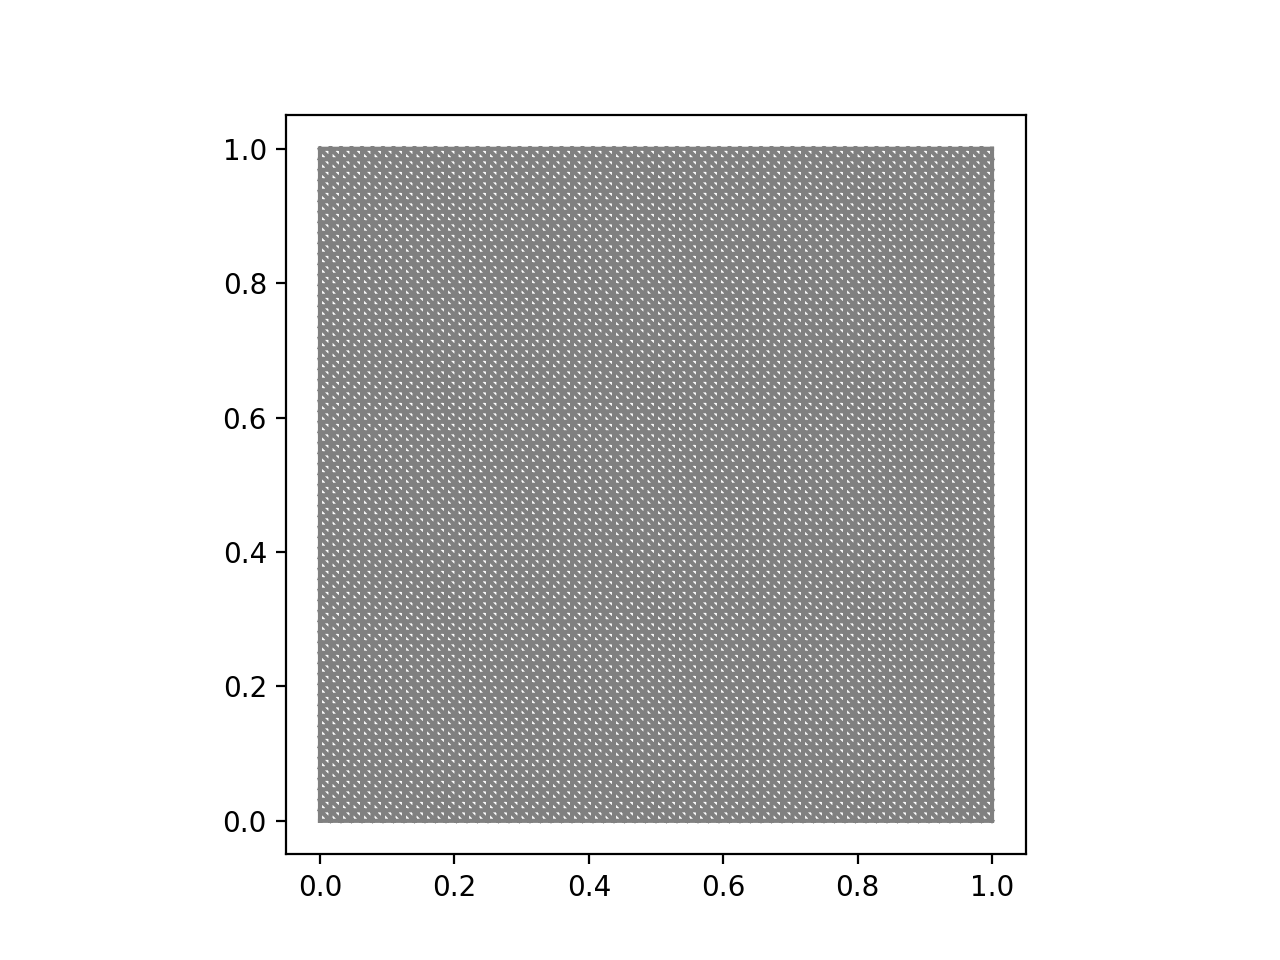

In [38]:
nx = 64
ny = 64
d = 1
mesh = UnitSquareMesh(nx, ny, "left")
Vh = FunctionSpace(mesh, "Lagrange", d)
print ("Number of dofs", Vh.dim())

plt.figure()
plot(mesh)

### 3. Define the Dirichlet boundary condition

We define the Dirichlet boundary condition $u = u_d := \sin(\pi x)$ on $\Gamma_D$.

In [97]:
def boundary_d(x, on_boundary):
    return (x[1] < DOLFIN_EPS or x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS) and on_boundary

u_d  = Expression("sin(DOLFIN_PI*x[0])", degree = d+2)
# bcs = [DirichletBC(Vh, u_d, boundary_d)]
# Create MeshFunction 
facet_data = MeshFunction('size_t', mesh, mesh.topology().dim()-1)    

# Declare classes inheriting from SubDomain and write
# your own version of inside() function, that determines
# which edge/face/cell (depending on MeshFunction dim) you 
# want to label
class DirichletBdry(SubDomain):
    def inside(self, x, on_boundary):
        return (x[1] < DOLFIN_EPS or x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS) and on_boundary
        
class NeumannBdry(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[1] > 1.-DOLFIN_EPS)     

# just an example of interior edges
# class Interface(SubDomain):
#     def inside(self, x, on_boundary):
#         return near(x[0], 0.5) and 0.25 < x[1] < 0.75   

# Mark all edges with label = 0
facet_data.set_all(0)

# Instantiate classe that prescribe boundaries
gamma_D = DirichletBdry()
gamma_N = NeumannBdry()
# interface = Interface() # not used

# Mark Dirichlet and Neumann boundaries with 1 and 2 respectively
gamma_D.mark(facet_data, 1)
gamma_N.mark(facet_data, 2)

# Mark interface with 3, not used anywhere
# interface.mark(facet_data, 3)

# Save labels in vtk format
out = File("mesh_labels.pvd")
out << facet_data

# DirichletBC is now constructed differently, 
#    3rd argument - MeshFunction
#    4th argument - label of the boundary on which to
#                   enforce BC
bcs = [DirichletBC(Vh, u_d, facet_data, 1)]

# For Neumann - get new measure, i.e. 
# let integrals now of the labeling of the edges
# so my_ds(i) would stand for integration over 
# external edges with label i
my_ds = Measure("ds", subdomain_data=facet_data)

### 4. Define the variational problem

We write the variational problem $a(u_h, v_h) = F(v_h)$. Here, the bilinear form $a$ and the linear form $L$ are defined as

- $a(u_h, v_h) := \int_\Omega \nabla u_h \cdot \nabla v_h \, dx$
- $L(v_h) := \int_\Omega f v_h \, dx + \int_{\Gamma_N} g \, v_h \, dx$.

$u_h$ denotes the trial function and $v_h$ denotes the test function.  The coefficients $f = 0$ and $g = \pi\, e^{\pi y} \sin( \pi x) $ are also given.

In [98]:
uh = TrialFunction(Vh)
vh = TestFunction(Vh)
k = Expression("x[0]", degree=d)

f = Constant(0.)
g = Expression("DOLFIN_PI*exp(DOLFIN_PI*x[1])*sin(DOLFIN_PI*x[0])", degree=d+2)
a = inner(grad(uh), grad(vh))*dx

# Here my_ds(2) indicates integration over gamma_N only 
L = f*vh*dx + g*vh*my_ds(2)

### 5. Assemble and solve the finite element discrete problem

We now assemble the finite element stiffness matrix $A$ and the right hand side vector $b$. Dirichlet boundary conditions are applied at the end of the finite element assembly procedure and before solving the resulting linear system of equations.

<IPython.core.display.Javascript object>


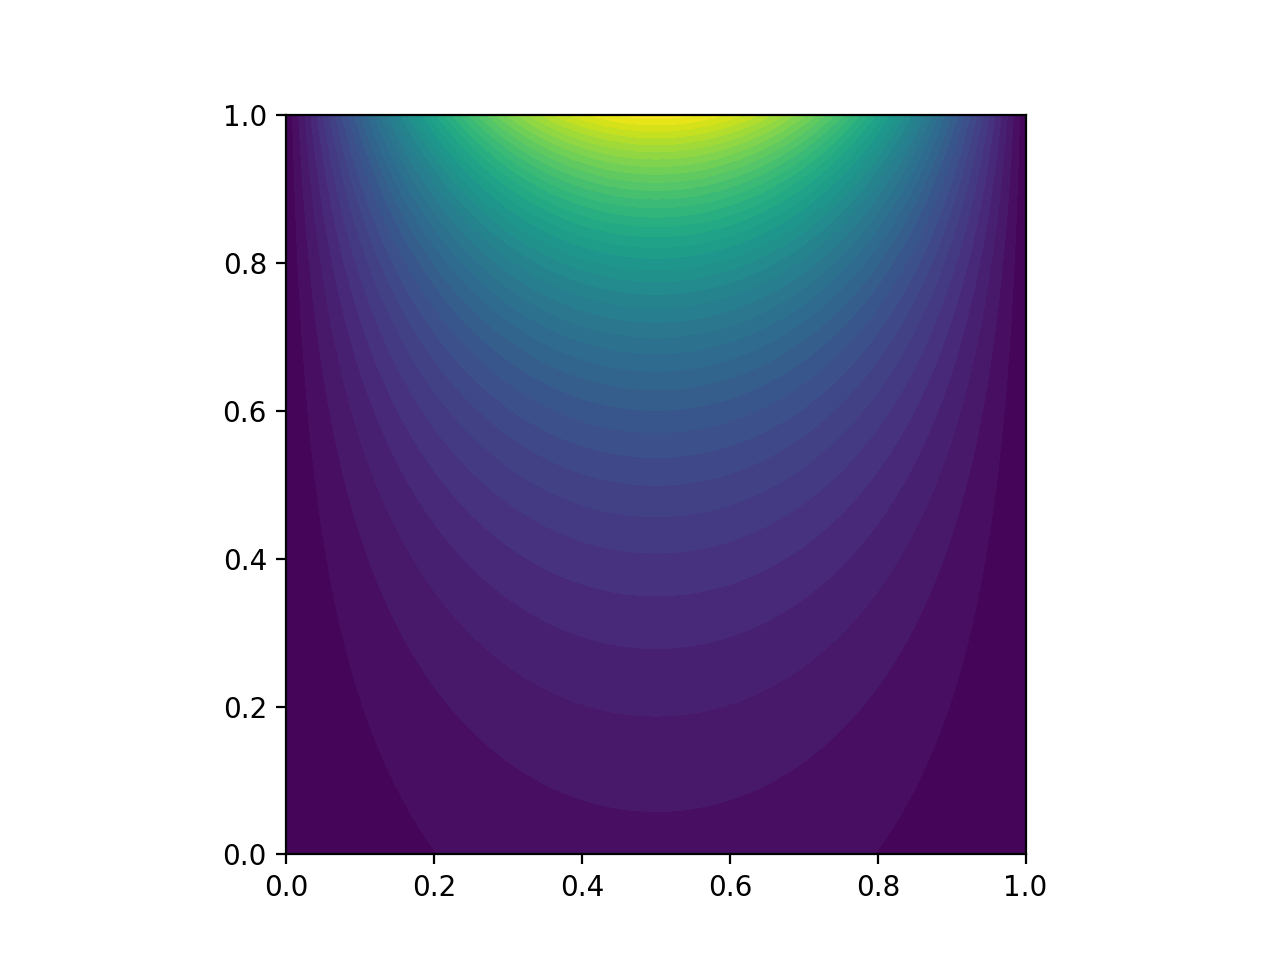

In [99]:
A, b = assemble_system(a, L, bcs)
uh = Function(Vh)
solve(A, uh.vector(), b)

plt.figure()
plot(uh)

out = File('temperature.pvd')
out << uh

# Example of VectorFunctionSpace and
# vector valued Expressions
Mh = VectorFunctionSpace(mesh, 'CG', 1)
k = Expression(("cos(x[0])", "sin(x[1])"), degree=d)
fh = Function(Mh)
fh = interpolate(k, Mh)

out = File('vector_function.pvd')
out << fh

### 6. Compute error norms

We then compute the $L^2(\Omega)$ and the energy norm of the difference between the exact solution and the finite element approximation.

In [100]:
u_ex = Expression("exp(DOLFIN_PI*x[1])*sin(DOLFIN_PI*x[0])", degree = d+2, domain=mesh)
grad_u_ex = Expression( ("DOLFIN_PI*exp(DOLFIN_PI*x[1])*cos(DOLFIN_PI*x[0])",
                         "DOLFIN_PI*exp(DOLFIN_PI*x[1])*sin(DOLFIN_PI*x[0])"), degree = d+2, domain=mesh )

norm_u_ex   = math.sqrt(assemble(u_ex**2*dx))
norm_grad_ex = math.sqrt(assemble(inner(grad_u_ex, grad_u_ex)*dx))

err_L2   = math.sqrt(assemble((uh - u_ex)**2*dx))
err_grad = math.sqrt(assemble(inner(grad(uh) - grad_u_ex, grad(uh) - grad_u_ex)*dx))

print ("|| u_ex - u_h ||_L2 / || u_ex ||_L2 = ", err_L2/norm_u_ex)
print ("|| grad(u_ex - u_h)||_L2 / = || grad(u_ex)||_L2 ", err_grad/norm_grad_ex)

|| u_ex - u_h ||_L2 / || u_ex ||_L2 =  0.000426753977446
|| grad(u_ex - u_h)||_L2 / = || grad(u_ex)||_L2  0.0245370404851
